In [75]:
import pandas as pd 
import matplotlib.pyplot as plt
import numpy as np

data_price = pd.read_csv(r"C:\Users\Bogdan\OneDrive - University of Warwick\Desktop\Projects\Short-Term WTI Price Forecasting\Spread trading startegy\Data.csv")

data_price['Spread'] = data_price['Dubai Price'] - data_price['WTI']

dynamic_mean = []
running_total = 0

for i in range(len(data_price)):
    running_total += data_price['Spread'].iloc[i]
    current_mean = running_total / (i + 1) # i+1 because index starts from 0
    dynamic_mean.append(current_mean)

data_price['Dynamic_Mean'] = dynamic_mean
spread_std = data_price['Spread'].std()

data_price['Upper_threshold_spread'] = data_price['Dynamic_Mean'] + spread_std
data_price['Lower_threshold_spread'] = data_price['Dynamic_Mean'] - spread_std

data_price['Signal'] = 0
data_price.loc[data_price['Spread'] > data_price['Upper_threshold_spread'], 'Signal'] = -1  # Short Dubai / Long Texas
data_price.loc[data_price['Spread'] < data_price['Lower_threshold_spread'], 'Signal'] = 1   # Long Dubai / Short Texas

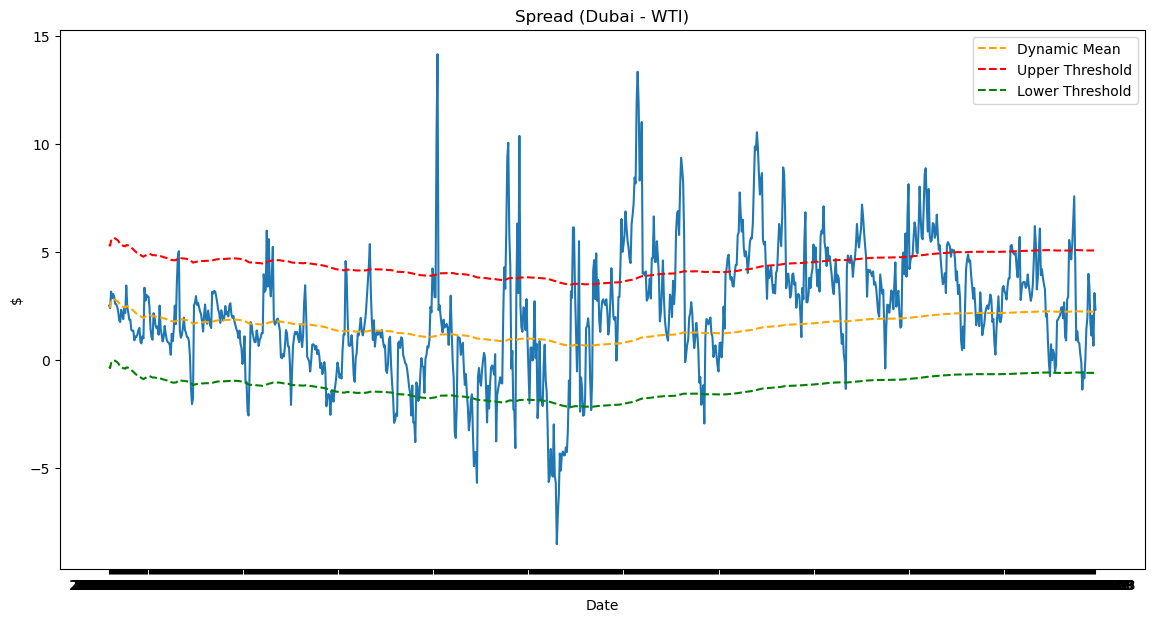

In [76]:
plt.figure(figsize=(14, 7))
plt.plot(data_price['DATE'], data_price['Spread'])
plt.plot(data_price['Dynamic_Mean'], color='orange', linestyle='--', label = "Dynamic Mean")
plt.plot(data_price['Upper_threshold_spread'], color='red', linestyle='--', label = 'Upper Threshold')
plt.plot(data_price['Lower_threshold_spread'], color='green', linestyle='--', label = 'Lower Threshold')
plt.title('Spread (Dubai - WTI)')
plt.xlabel('Date')
plt.ylabel('$')
plt.legend()

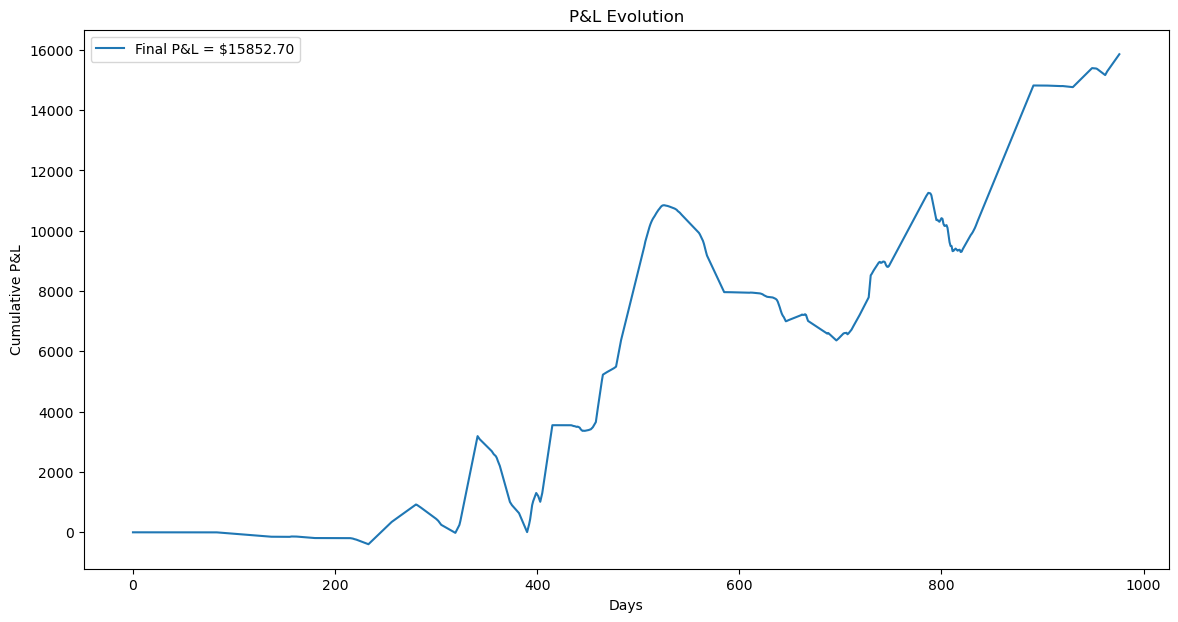

In [78]:
data_price["Daily P&L"] = 0.0
net_position = 0  # +1 for long Dubai / short Texas, -1 for short Dubai / long Texas
average_spread_value = []

for i in data_price.index:
    mean_spread = data_price.iloc[i]['Dynamic_Mean']
    current_spread = data_price.iloc[i]["Spread"]
    signal = data_price.iloc[i]['Signal']

    if signal == 1:
        net_position += 1
        average_spread_value.append(current_spread)

    if signal == -1:
        net_position -= 1
        average_spread_value.append(current_spread)

    if abs(current_spread - mean_spread) < 0.01 and net_position >= 1:
        data_price.loc[i, "Daily P&L"] = (current_spread - np.array(average_spread_value).mean()) * net_position
        net_position = 0  #Clear positions at the mean
        average_spread_value.clear() #Clear positions at the mean

    if abs(current_spread - mean_spread) < 0.01 and net_position <= -1:
        data_price.loc[i, "Daily P&L"] = (np.array(average_spread_value).mean() - current_spread) * abs(net_position)
        net_position = 0  # Clear positions at the mean
        average_spread_value.clear() #Clear positions at the mean

    if net_position >= 1:
        data_price.loc[i, "Daily P&L"] = (current_spread - np.array(average_spread_value).mean()) * net_position

    if net_position <= -1:
        data_price.loc[i, "Daily P&L"] = (np.array(average_spread_value).mean() - current_spread) * abs(net_position)

    if signal == 0 and i > 0:
        data_price.loc[i, "Daily P&L"] = data_price.loc[i-1, "Daily P&L"]

# Calculate cumulative P&L
data_price["Cumulative P&L"] = data_price["Daily P&L"].cumsum()

# Plotting
plt.figure(figsize=(14, 7))
plt.plot(data_price.index, data_price["Cumulative P&L"], label=f"Final P&L = ${data_price['Cumulative P&L'].iloc[-1]:.2f}")
plt.title("P&L Evolution")
plt.ylabel("Cumulative P&L")
plt.xlabel("Days")
plt.legend()
